#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час и построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics import tsaplots

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

### Загрузка данных, входной анализ и ресемплирование

Загрузка данных:

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('D:\\data\\taxi.csv', index_col=[0], parse_dates=[0])

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Индекс представлен датой, также есть колонка с количеством заказов. Нет пропусков, тип данных корректный. Данные с 1 марта 2018 года по 31 августа 2018 года. Записи обновляются каждые 10 минут.

Отсортирую индексы, ресемплирую их по одному часу. Возьму суммарное количество заказов:

In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

Проверка:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Записей стало заметно меньше - 4416. Также проверю, в правильном ли порядке расположены временные ряды:

In [7]:
data.index.is_monotonic

True

Да, все верно. Можно приступать к анализу данных.

**Промежуточный вывод:** индекс представлен датой, также есть колонка с количеством заказов. Нет пропусков, тип данных корректный. Данные с 1 марта 2018 года по 31 августа 2018 года. Данные ресемплированы 1 часом. Хронологический порядок верный. Отрицательных значений нет.

## Анализ

Ресемплирую данные одним днем и посмотрю на график:

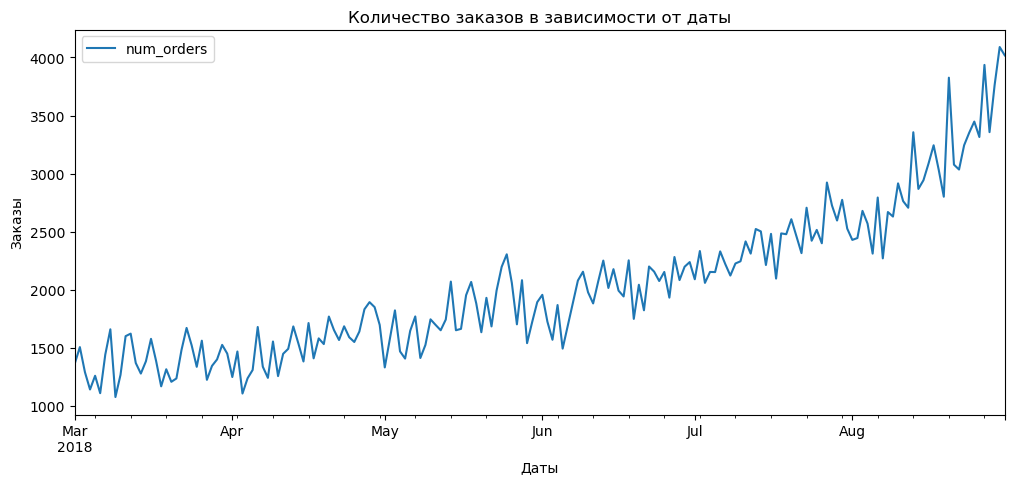

In [8]:
plt.rcParams['figure.figsize'] = [12, 5]

data.resample('1D').sum().plot()

plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.title("Количество заказов в зависимости от даты");

Просмотрю скользящие средние значения из столбца "num_orders" с окном равным 10 периодам:

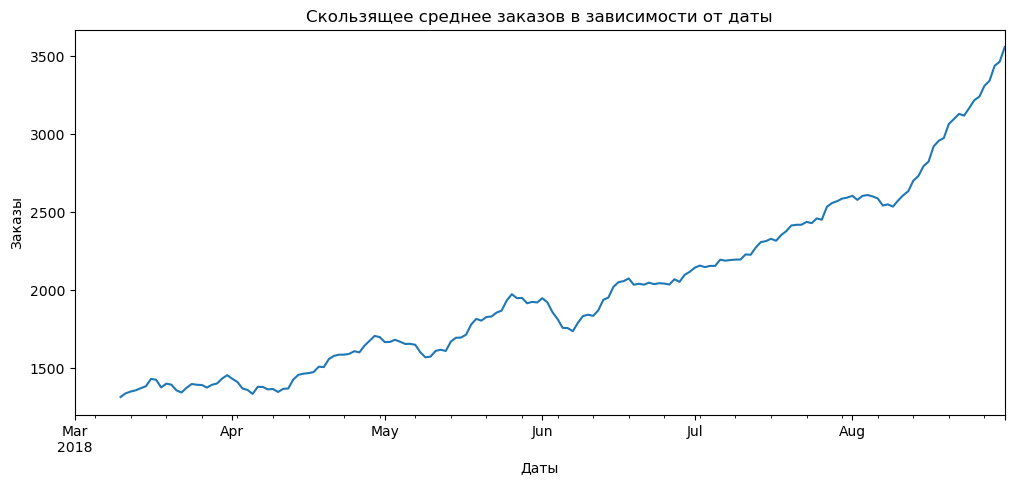

In [9]:
data.resample('1D').sum()['num_orders'].rolling(10).mean().plot()

plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.title("Скользящее среднее заказов в зависимости от даты")
plt.show()

На графиках видно, что количество заказов растет, колебания в количестве заказов заметные, то есть количество заказов может как увеличиваться, так и уменьшаться.

Посмотрю на графики с трендом, сезонностью и остатками с исходным ресемплированием по 1 часу:

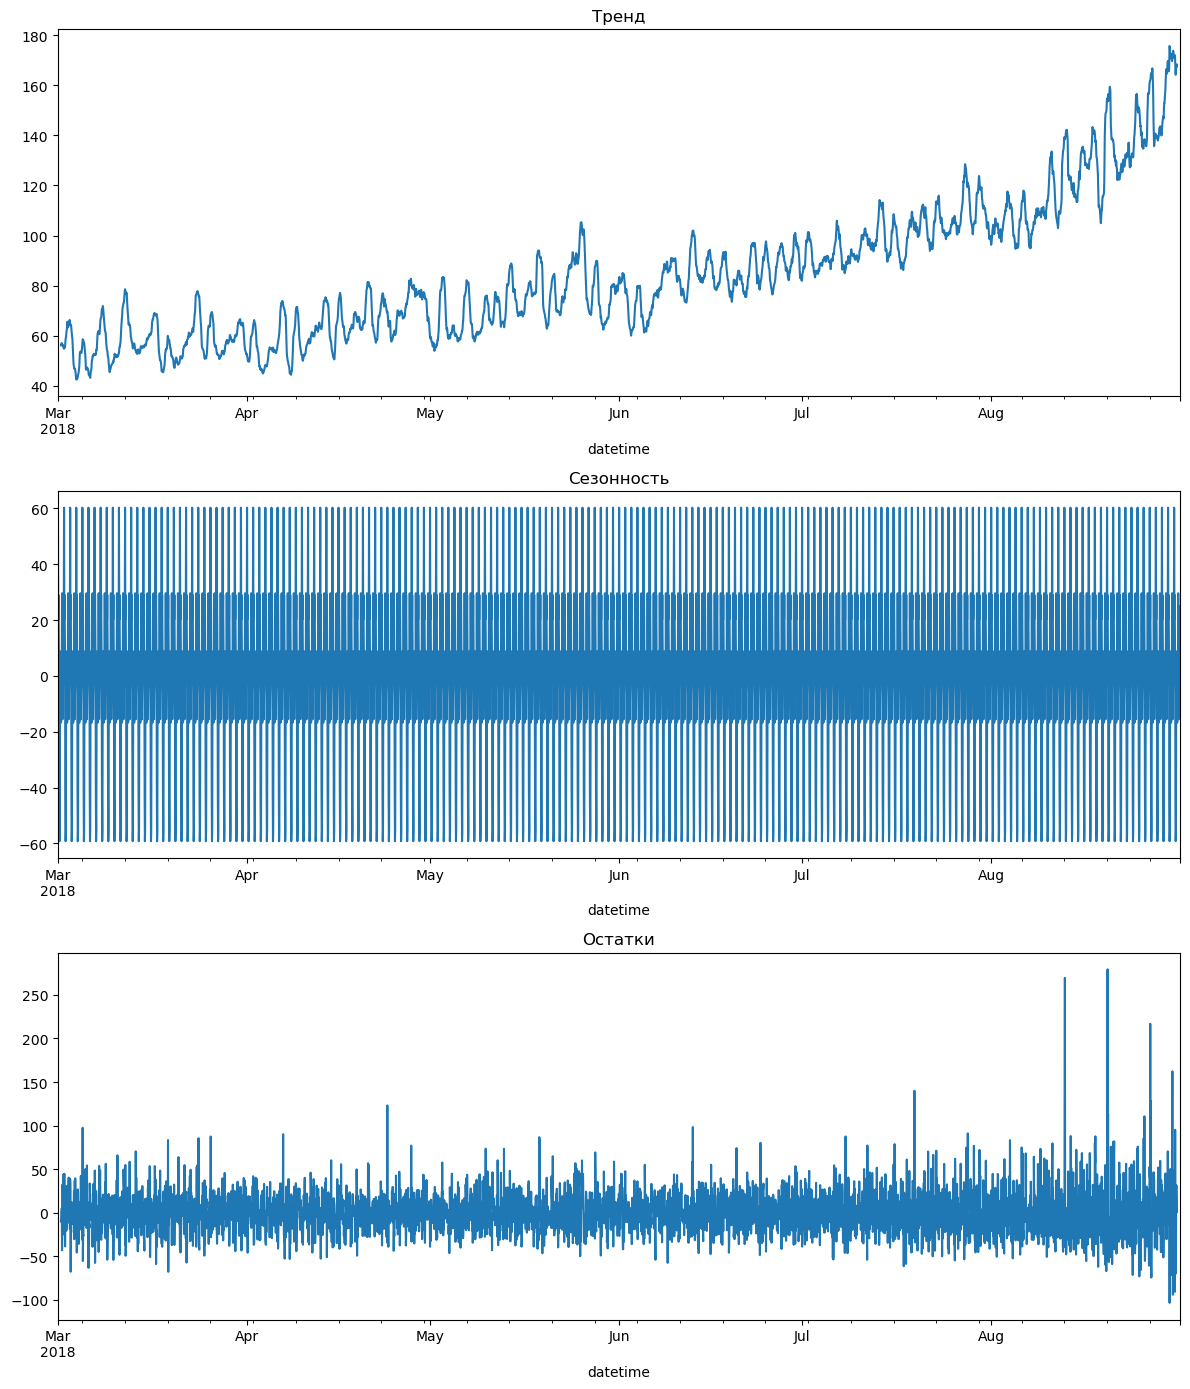

In [10]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(12, 14))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.tight_layout()

Еще одно подтверждение - количество заказов растет (это видно по графику трендов). Тренд с заметным ускорением в августе, в июле тоже есть ускорение, но совсем небольшое. Так как это данные о заказах такси в аэропортах, можно предположить, что ускорение связано с периодом отпусков.
Доля остатков не на всем протяжении одинаковая, есть сильно отличающиеся значения ближе к концу графика. Поэтому расхождения между RMSE теста и подбора параметров может отличаться и по этой причине. 

Так как график сезонности не очень читаемый, я более детально рассмотрю данные за 1 неделю:

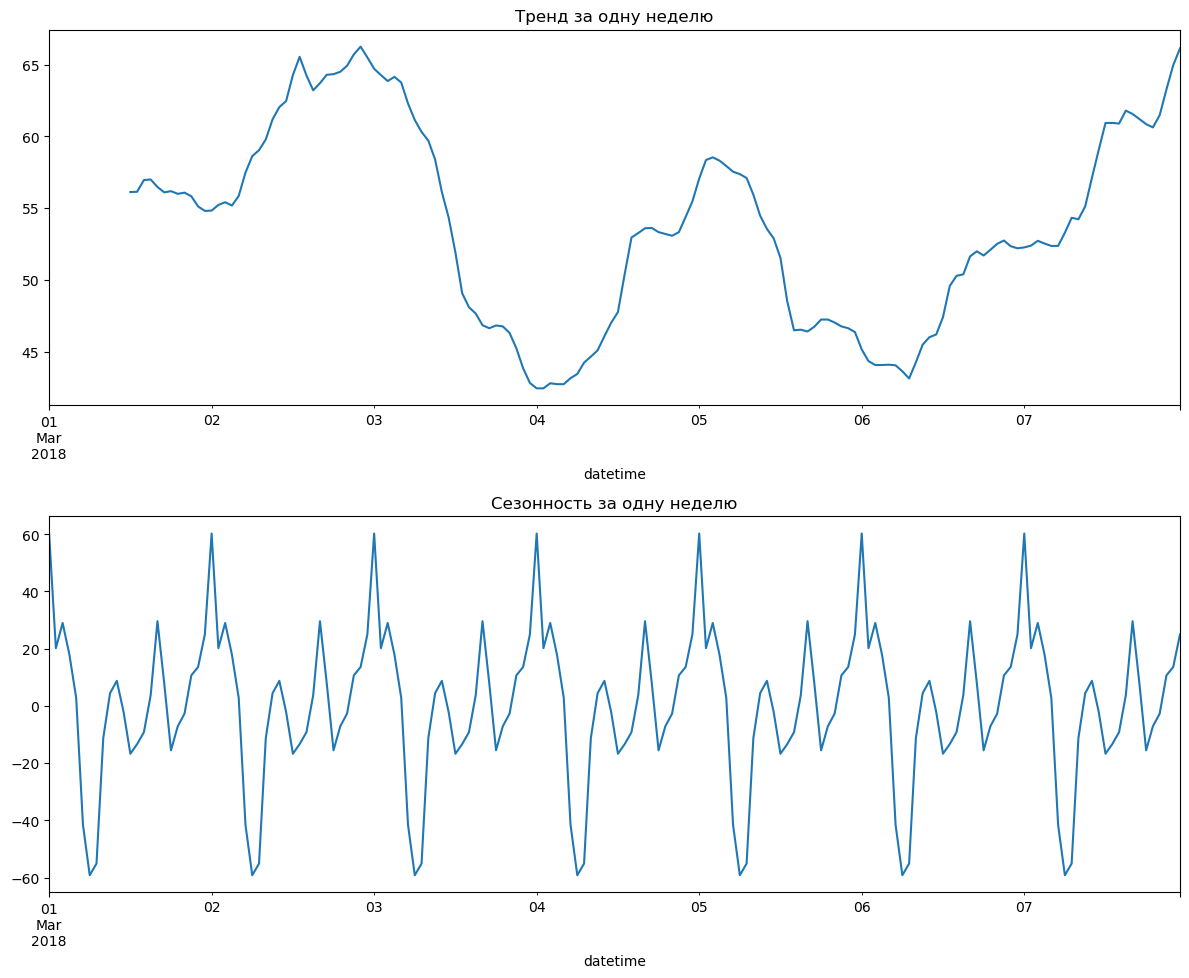

In [11]:
plt.figure(figsize=(12, 14))
plt.subplot(311)
decomposed.trend['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Тренд за одну неделю')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca()) 
plt.title('Сезонность за одну неделю')
plt.tight_layout()

Сценарий повторяется каждый день. Ночью заказов мало, вечером заказов много. Видно, что в разные дни активность разная. А значит день недели будет важен для модели, как и час.

**Промежуточный вывод:** 
- количество заказов растет.
- график сезонности показывает, что каждый день примерно в одинаковое время количество заказов похоже.
- тренд с заметным ускорением в августе, в июле тоже есть ускорение, но совсем небольшое. Так как это данные о заказах такси в аэропортах, можно предположить, что ускорение связано с периодом отпусков.
- доля остатков не на всем протяжении одинаковая, есть сильно отличающиеся значения ближе к концу графика. Поэтому расхождения между RMSE теста и подбора параметров может отличаться и по этой причине. 
- в разные дни активность разная. А значит день недели будет важен для модели.

## Обучение

Я обучу 4 модели: Linear Regression, Lasso, LGBMRegressor, CatBoostRegressor. Сначала создам новые признаки и разделю данные на выборки.

### Создание признаков

Надо создать новые признаки для прогнозирования. Это будет день, час, день недели, лаги num_orders, скользящее среднее. Функция для создания признаков:

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # Словарь для хранения смещенных данных
    lagged_data_dict = {}

    for lag in range(1, max_lag + 1):
        lagged_data_dict['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    lagged_data = pd.DataFrame(lagged_data_dict)

    data = pd.concat([data, lagged_data], axis=1)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Данные ресемплированы 1 часом. Нужно выбрать значение max_lag и rolling_mean_size.

max_lag: для расчета max_lag посчитаю автокорелляцию лагов с таргетом.

rolling_mean_size: я хочу оценить среднее значение за последний день, поэтому выберу rolling_mean_size=24.

Расчет для выбора значения max_lag:

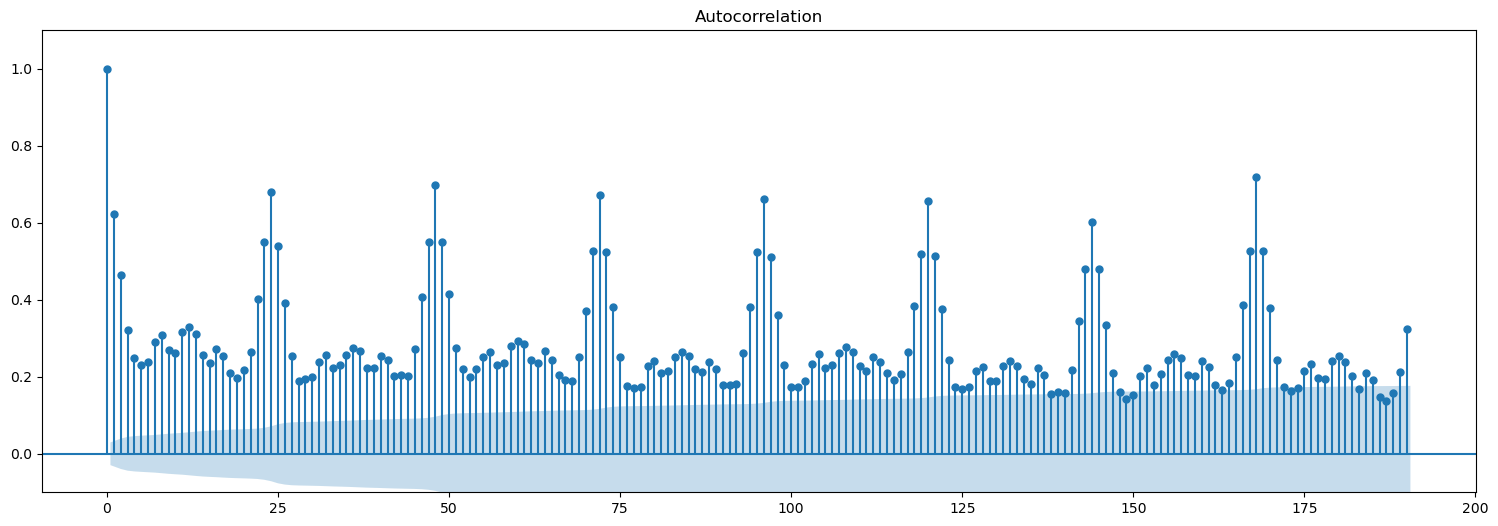

In [13]:
fig = tsaplots.plot_acf(data['num_orders'],lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Выберу значение равное 170.

Применяю функцию:

In [14]:
data = make_features(data, 170, 24)

Почищу NaN:

In [15]:
data = data.dropna()

In [16]:
print("Количество записей:", data.shape[0])

Количество записей: 4246


In [17]:
data.head()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 02:00:00,65,2,8,3,78.0,143.0,94.0,127.0,108.0,76.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.750000
2018-03-08 04:00:00,60,4,8,3,68.0,65.0,78.0,143.0,94.0,127.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,61.833333
2018-03-08 05:00:00,6,5,8,3,60.0,68.0,65.0,78.0,143.0,94.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.291667
2018-03-08 06:00:00,6,6,8,3,6.0,60.0,68.0,65.0,78.0,143.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.125000


Можно разделять данные на выборки.

### Разделение данных на выборки

Разделю данные на выборки с соотношением 0.9/0.1:

In [18]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)

print(train.index.min(), train.index.max()) #проверка
print(test.index.min(), test.index.max())

2018-03-08 02:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


In [19]:
features = [col for col in train.columns if col != 'num_orders']
target = 'num_orders'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

### Обучение моделей и подбор гиперпараметров

In [20]:
# Создание скорера для расчета RMSE через grid search и cross_val_score
scorer = make_scorer(mean_squared_error, greater_is_better=False)

#### LinearRegression

Так как подбирать гиперпараметры у линейной регрессии не надо, я использую кросс-валидацию:

In [21]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

model_lr = LinearRegression()

# Выполнение кросс-валидации и вычисление RMSE
rmse_lr = np.sqrt(-cross_val_score(model_lr, X_train, y_train, scoring=scorer, cv=tscv))

# Вывод результатов
print("RMSE обучающей выборки (кросс-валидация):", rmse_lr)
print("Средний RMSE обучающей выборки (кросс-валидация):", np.mean(rmse_lr))

RMSE обучающей выборки (кросс-валидация): [20.39494992 20.998413   21.73202252 22.29971754 28.0762682 ]
Средний RMSE обучающей выборки (кросс-валидация): 22.70027423524231
Wall time: 150 ms


#### Lasso

In [22]:
%%time

# Определение гиперпараметров для подбора
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'max_iter': range(10000, 50001, 2000),
    'tol': [0.0001, 0.001, 0.01]
}

# Создание модели
model_lasso = Lasso(random_state=42)

# Создание объекта RandomizedSearchCV
random_search_lasso = RandomizedSearchCV(
    estimator=model_lasso,
    param_distributions=param_grid,
    scoring=scorer,
    cv=tscv,
    n_iter=10,
    random_state=42,
    verbose=1
)

random_search_lasso.fit(X_train, y_train)

# Лучшие найденные гиперпараметры
best_params = random_search_lasso.best_params_
print("Лучшие гиперпараметры:", best_params)

print("Lasso RMSE:", np.sqrt(-random_search_lasso.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие гиперпараметры: {'tol': 0.01, 'max_iter': 28000, 'alpha': 10.0}
Lasso RMSE: 22.15336909036685
Wall time: 16.3 s


#### CatBoostRegressor

In [23]:
%%time

catboost_model = CatBoostRegressor(random_seed=42)

catboost_param_grid = {
    'iterations': range(100, 1001, 100),
    'learning_rate': [0.01, 0.1, 1],
    'depth': range(3, 11)
}

catboost_grid_search = RandomizedSearchCV(estimator=catboost_model, param_distributions=catboost_param_grid, \
                                    scoring=scorer, cv=tscv, verbose=1, random_state=42)

catboost_grid_search.fit(X_train, y_train)

print("CatBoostRegressor:")
print("Лучшие гиперпараметры:", catboost_grid_search.best_params_)
print("Лучшая RMSE:", np.sqrt(-catboost_grid_search.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 29.1826361	total: 143ms	remaining: 2m 8s
1:	learn: 29.0452446	total: 150ms	remaining: 1m 7s
2:	learn: 28.9324036	total: 157ms	remaining: 46.9s
3:	learn: 28.7932882	total: 164ms	remaining: 36.6s
4:	learn: 28.7073061	total: 170ms	remaining: 30.5s
5:	learn: 28.6157277	total: 177ms	remaining: 26.4s
6:	learn: 28.4927853	total: 184ms	remaining: 23.5s
7:	learn: 28.3772502	total: 191ms	remaining: 21.3s
8:	learn: 28.2721519	total: 197ms	remaining: 19.6s
9:	learn: 28.1668709	total: 204ms	remaining: 18.2s
10:	learn: 28.0553455	total: 211ms	remaining: 17s
11:	learn: 27.9476357	total: 218ms	remaining: 16.1s
12:	learn: 27.8370085	total: 224ms	remaining: 15.3s
13:	learn: 27.7322364	total: 231ms	remaining: 14.6s
14:	learn: 27.6245213	total: 238ms	remaining: 14s
15:	learn: 27.5173649	total: 244ms	remaining: 13.5s
16:	learn: 27.4053238	total: 251ms	remaining: 13.1s
17:	learn: 27.2940098	total: 258ms	remaining: 12.6s
18:	learn: 27.199

#### LGBMRegressor

In [24]:
%%time

lgbm_model = LGBMRegressor(seed=42)

lgbm_param_grid = {
    'n_estimators': range(100, 2001, 100),
    'learning_rate': [0.01, 0.1, 1]
}

lgbm_grid_search = RandomizedSearchCV(estimator=lgbm_model, param_distributions=lgbm_param_grid, \
                                    scoring=scorer, cv=tscv, verbose=1, random_state=42)

lgbm_grid_search.fit(X_train, y_train)

print("LGBMRegressor:")
print("Лучшие параметры:", lgbm_grid_search.best_params_)
print("Лучшая RMSE:", np.sqrt(-lgbm_grid_search.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
LGBMRegressor:
Лучшие параметры: {'n_estimators': 600, 'learning_rate': 0.01}
Лучшая RMSE: 23.072466631880765
Wall time: 5min 32s


Результат:

| Название модели | RMSE   | Гиперпараметры                  |
|-----------------|--------|---------------------------------|
| LinearRegression| 22.70 | -                               |
| LGBMRegressor    | 23.07  | 'n_estimators': 600, 'learning_rate': 0.01 |
| CatBoostRegressor | 22.79 | 'learning_rate': 0.01, 'iterations': 900, 'depth': 3  |
| Lasso           | 22.15 | 'tol': 0.01, 'max_iter': 28000, 'alpha': 10.0 |

На тесте проверю Lasso. Если она не пройдет проверку - остальные модели.

## Тестирование

Протестирую Lasso:

In [25]:
lasso_model = Lasso(random_state=42, tol=0.01, max_iter=28000, alpha=10)

lasso_model.fit(X_train, y_train)

predicted_lasso = lasso_model.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, predicted_lasso))

# Вывод результатов
print("RMSE тестовой выборки lasso:", rmse_lasso)

RMSE тестовой выборки lasso: 34.477404558452236


Проверю модель на адекватность с помощью прогноза предыдущих значений ряда:

In [26]:
pred_previous = y_test.shift(1)
pred_previous.iloc[0] = y_train.iloc[-1]
rmse_previous = np.sqrt(mean_squared_error(y_test, pred_previous))
print("RMSE:", rmse_previous)

RMSE: 58.819724582830204


RMSE на тесте = 34.48, а RMSE при проверке на адекватность модели = 58.82<br>
Так как RMSE на тесте меньше, чем RMSE при проверке на адекватность - тестирование прошло успешно.

## Общий вывод <br>

1. Данные были проверены и ресемплированы одним часом.
2. Также данные были проанализированы. Количество заказов растет, ситуация с заказами повторяется ежесуточно.
3. Были созданы новые признаки для прогнозирования временного ряда, также данные разбиты на выборки.
4. Подобраны гиперпараметры 3 моделей: Lasso, CatBoost, LGBM. Также проведена кросс-валидация Linear Regression.
5. Лучший результат показала модель Lasso. RMSE=22.15.
6. Модель Lasso проверена на тестовой выборке. Результат RMSE=34.48.
7. Проведена проверка на адекватность модели. Модель эту проверку прошла, тестирование прошло успешно.

**Выбранная модель - Lasso с параметрами tol=0.01, max_iter=28000, alpha=10.**